In [4]:
import pandas as pd
df = pd.read_csv('../data/complaints.csv')
df.head()

C:\Users\user\AppData\Local\Temp\ipykernel_10608\3501533415.py:2: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../data/complaints.csv')


,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,2025-06-20,Credit reporting or other personal consumer re...,Credit reporting,Incorrect information on your report,Information belongs to someone else,NaN,NaN,Experian Information Solutions Inc.,FL,32092,NaN,NaN,Web,2025-06-20,In progress,Yes,NaN,14195687
1,2025-06-20,Debt collection,Telecommunications debt,Attempts to collect debt not owed,Debt is not yours,NaN,Company can't verify or dispute the facts in t...,"Eastern Account Systems of Connecticut, Inc.",FL,342XX,NaN,NaN,Web,2025-06-20,Closed with explanation,Yes,NaN,14195688
2,2025-06-20,Credit reporting or other personal consumer re...,Credit reporting,Improper use of your report,Reporting company used your report improperly,NaN,NaN,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",AZ,85225,NaN,NaN,Web,2025-06-20,In progress,Yes,NaN,14195689
3,2025-06-20,Credit reporting or other personal consumer re...,Credit reporting,Improper use of your report,Reporting company used your report improperly,NaN,NaN,Experian Information Solutions Inc.,AZ,85225,NaN,NaN,Web,2025-06-20,In progress,Yes,NaN,14195690
4,2025-06-20,Credit reporting or other personal consumer re...,Credit reporting,Incorrect information on your report,Account status incorrect,NaN,NaN,Experian Information Solutions Inc.,IL,60628,NaN,NaN,Web,2025-06-20,In progress,Yes,NaN,14195692


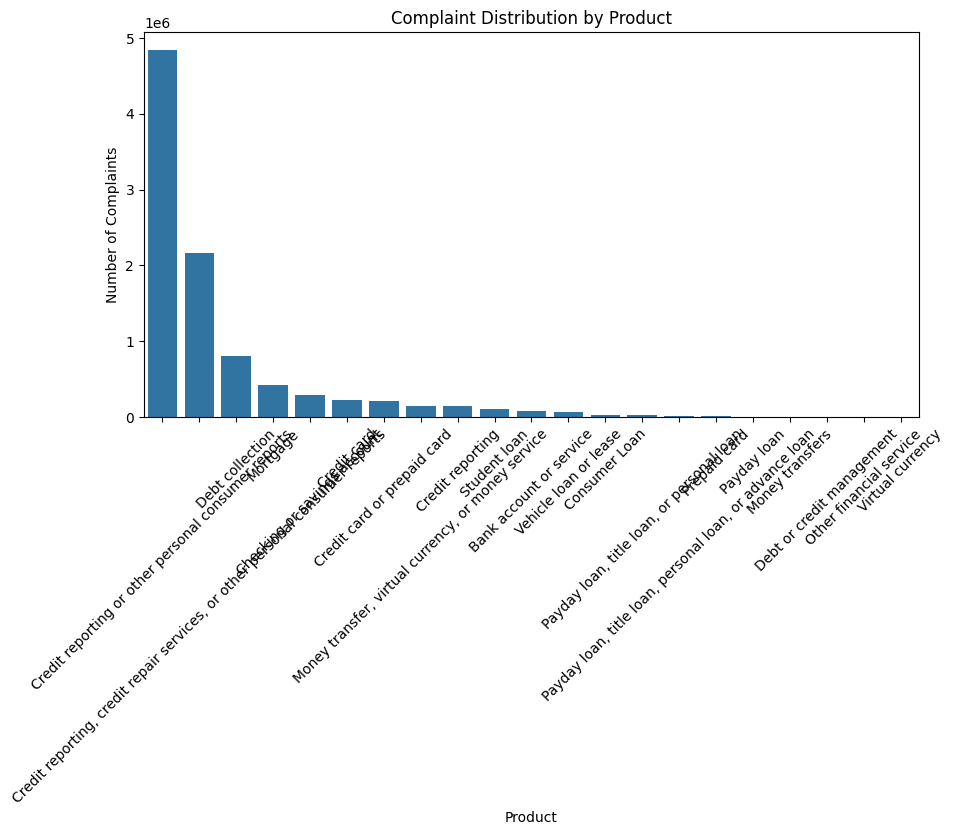

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

product_counts = df['Product'].value_counts()
plt.figure(figsize=(10,5))
sns.barplot(x=product_counts.index, y=product_counts.values)
plt.title('Complaint Distribution by Product')
plt.xlabel('Product')
plt.ylabel('Number of Complaints')
plt.xticks(rotation=45)
plt.show()

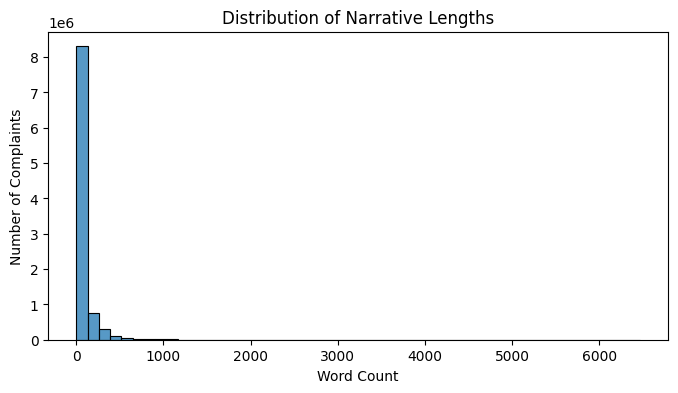

In [6]:
df['narrative_length'] = df['Consumer complaint narrative'].astype(str).apply(lambda x: len(x.split()))
plt.figure(figsize=(8,4))
sns.histplot(df['narrative_length'], bins=50)
plt.title('Distribution of Narrative Lengths')
plt.xlabel('Word Count')
plt.ylabel('Number of Complaints')
plt.show()

In [7]:
with_narrative = df['Consumer complaint narrative'].notnull().sum()
without_narrative = df['Consumer complaint narrative'].isnull().sum()
print(f"Complaints with narrative: {with_narrative}")
print(f"Complaints without narrative: {without_narrative}")

Complaints with narrative: 2980756
Complaints without narrative: 6629041


In [8]:
target_products = [
    'Credit card', 'Personal loan', 'Buy Now, Pay Later (BNPL)', 'Savings account', 'Money transfers'
]

df_filtered = df[df['Product'].isin(target_products)]
df_filtered = df_filtered[df_filtered['Consumer complaint narrative'].notnull()]

In [9]:
import re

def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z0-9\s]', '', text)  # Remove special characters
    text = re.sub(r'i am writing to file a complaint.*', '', text)  # Remove boilerplate (optional)
    return text.strip()

df_filtered['cleaned_narrative'] = df_filtered['Consumer complaint narrative'].apply(clean_text)

In [10]:
df_filtered.to_csv('../data/filtered_complaints.csv', index=False)

In [1]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
import pandas as pd

# Load your filtered data
df = pd.read_csv('../data/filtered_complaints.csv')

# Set chunk size and overlap (experiment with values, e.g., 300 and 50)
chunk_size = 300
chunk_overlap = 50

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=chunk_size,
    chunk_overlap=chunk_overlap
)

# Apply chunking to each narrative
chunks = []
for idx, row in df.iterrows():
    narrative = row['cleaned_narrative']
    if pd.isnull(narrative):
        continue
    narrative = str(narrative)
    splits = text_splitter.split_text(narrative)
    for chunk in splits:
        chunks.append({
            'complaint_id': row['Complaint ID'] if 'Complaint ID' in row else idx,
            'product': row['Product'],
            'company': row['Company'] if 'Company' in row else '',
            'date': row['Date received'] if 'Date received' in row else '',
            'chunk': chunk
        })

# Convert to DataFrame for easier handling
chunks_df = pd.DataFrame(chunks)
chunks_df.to_csv('../data/chunked_complaints.csv', index=False)

In [2]:
import pandas as pd
from sentence_transformers import SentenceTransformer
import faiss
import numpy as np
import os

# Load chunked data
chunks_df = pd.read_csv('../data/chunked_complaints.csv')

# Load embedding model
model = SentenceTransformer('all-MiniLM-L6-v2')

# Generate embeddings for each chunk
embeddings = model.encode(chunks_df['chunk'].tolist(), show_progress_bar=True)

# Create FAISS index
dimension = embeddings.shape[1]
index = faiss.IndexFlatL2(dimension)
index.add(np.array(embeddings).astype('float32'))

# Save index and metadata
os.makedirs('vector_store', exist_ok=True)
faiss.write_index(index, 'vector_store/complaints_faiss.index')
chunks_df.to_csv('vector_store/metadata.csv', index=False)

print("Embeddings and FAISS index saved!")

C:\Users\user\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Batches: 100%|███████████| 12878/12878 [1:45:19<00:00,  2.04it/s]


Embeddings and FAISS index saved!


In [3]:
import pandas as pd
df = pd.read_csv('../data/chunked_complaints.csv')
print(df.head())
print(df.shape)

   complaint_id      product  \
0      14069121  Credit card   
1      14069121  Credit card   
2      14047085  Credit card   
3      14047085  Credit card   
4      14047085  Credit card   

                                               chunk  
0  a xxxx xxxx card was opened under my name by a...  
1  and immediately closed the card however they h...  
2  dear cfpb i have a secured credit card with ci...  
3  my check but their system doesnt have info as ...  
4  i requested a case number but they wont send m...  
(412073, 3)
